# Onchain Market Making for USD+/wETH and USD+/cbBTC

This notebook focuses on implementing market making strategies for onchain trading via 1inch PMM and Hashflow PMM.

In [1]:
# Import necessary libraries

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from datetime import datetime, timedelta

import sys
import os
import importlib.util



# Configure plotting

plt.style.use('ggplot')

%matplotlib inline



# Add project root to path

sys.path.append('..')

In [2]:
# Display system path to diagnose import issues
print("Python sys.path:")
for p in sys.path:
    print(f"  - {p}")

# Import the market_data module directly
import os
import importlib.util

# Use absolute path to the module
project_root = os.path.abspath('..')
market_data_path = os.path.join(project_root, 'src', 'utils', 'market_data.py')
print(f"\nLooking for market_data.py at: {market_data_path}")

if os.path.exists(market_data_path):
    print(f"✅ File exists")
    
    # Import the module using importlib
    spec = importlib.util.spec_from_file_location("market_data", market_data_path)
    market_data = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(market_data)
    
    # Get MarketDataHandler class from the module
    MarketDataHandler = getattr(market_data, 'MarketDataHandler')
    OnchainDataHandler = getattr(market_data, 'OnchainDataHandler')
    
    print(f"✅ Successfully imported MarketDataHandler: {MarketDataHandler}")
else:
    print(f"❌ File does not exist: {market_data_path}")

# Import other project modules directly
from src.models.avellaneda_stoikov import AvellanedaStoikovModel
from src.models.rl_enhanced_model import RLEnhancedModel
from src.backtesting.backtest_engine import BacktestEngine
from src.data.data_processor import DataProcessor

Python sys.path:
  - /opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python312.zip
  - /opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12
  - /opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/lib-dynload
  - 
  - /Users/nody/overnight/venv/lib/python3.12/site-packages
  - ..

Looking for market_data.py at: /Users/nody/overnight/src/utils/market_data.py
✅ File exists


✅ Successfully imported MarketDataHandler: <class 'market_data.MarketDataHandler'>


## 1. Simulating Onchain Market Data

In [3]:
# Generate base CEX data
data_processor = DataProcessor()

# Define date range
start_date = datetime.now() - timedelta(days=30)
end_date = datetime.now()
timestamps = pd.date_range(start=start_date, end=end_date, freq='1min')

# Generate price data
np.random.seed(42)
eth_price = 2000.0
eth_prices = [eth_price]

for _ in range(len(timestamps) - 1):
    eth_return = np.random.normal(0, 0.001)
    eth_price *= (1 + eth_return)
    eth_prices.append(eth_price)

# Create DataFrame for CEX data
cex_data = pd.DataFrame({
    'open': eth_prices,
    'high': [p * (1 + np.random.uniform(0, 0.002)) for p in eth_prices],
    'low': [p * (1 - np.random.uniform(0, 0.002)) for p in eth_prices],
    'close': eth_prices,
    'volume': np.random.uniform(10, 100, size=len(timestamps))
}, index=timestamps)

# Add technical features
cex_data = data_processor.add_technical_features(cex_data)

# Simulate onchain data with higher latency and wider spreads
onchain_data = data_processor.simulate_onchain_data(
    cex_data, 
    latency_range=(300, 800),  # Higher latency for onchain (ms)
    fee_range=(0.002, 0.008),  # Higher fees
    gas_cost_factor=1.2
)

# Display onchain data
print("Onchain ETH/USD+ Data:")
onchain_data.head()

/Users/nody/overnight/notebooks/../src/data/data_processor.py:284: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill').fillna(method='ffill').fillna(0)
/Users/nody/overnight/notebooks/../src/data/data_processor.py:417: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  latency_offsets = pd.TimedeltaIndex(latency_ms, unit='ms')
2025-05-02 18:59:52,195 - src.data.data_processor - INFO - Generated onchain data with latency range (300, 800)ms and fee range (0.002, 0.008)


Onchain ETH/USD+ Data:


,open,high,low,close,volume,returns,volatility,mid_price,ma_20,ma_50,...,latency_ms,fee_pct,spread,bid_price,ask_price,gas_cost_usd,slippage_1eth_pct,slippage_10eth_pct,effective_buy_price_1eth,effective_buy_price_10eth
2025-04-02 18:59:52.057480,2000.000000,2003.510713,1999.458890,2000.000000,88.742915,0.000497,0.00096,2000.000000,2003.366271,1993.889184,...,526.533245,0.461660,0.001206,1998.794460,2001.205540,14.869735,0.05,0.2,2017.075878,2006.694925
2025-04-02 19:00:52.057480,2000.993428,2003.137896,1999.978826,2000.993428,68.821459,0.000497,0.00096,2000.993428,2003.366271,1993.889184,...,634.751045,0.372464,0.001204,1999.788360,2002.198496,14.869735,0.05,0.2,2018.069331,2007.689867
2025-04-02 19:01:52.057480,2000.716762,2002.631532,1999.153571,2000.716762,24.502664,-0.000138,0.00096,2000.716762,2003.366271,1993.889184,...,776.070700,0.390461,0.001205,1999.511645,2001.921880,14.869735,0.05,0.2,2017.792576,2007.412697
2025-04-02 19:02:52.057480,2002.012604,2005.106990,2001.780234,2002.012604,41.035810,0.000648,0.00096,2002.012604,2003.366271,1993.889184,...,452.558027,0.723390,0.001209,2000.802707,2003.222501,14.869735,0.05,0.2,2019.093847,2008.715919
2025-04-02 19:03:52.057480,2005.061729,2008.033615,2001.864703,2005.061729,98.207103,0.001523,0.00096,2005.061729,2003.366271,1993.889184,...,477.508563,0.628222,0.001208,2003.851134,2006.272323,14.869735,0.05,0.2,2022.145195,2011.771842


## 2. Analyzing Onchain vs CEX Data

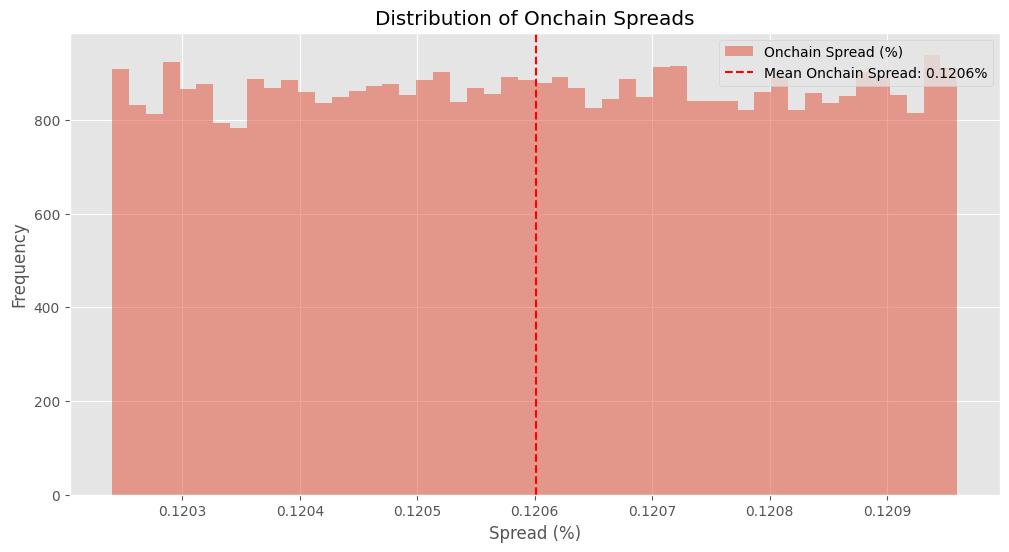

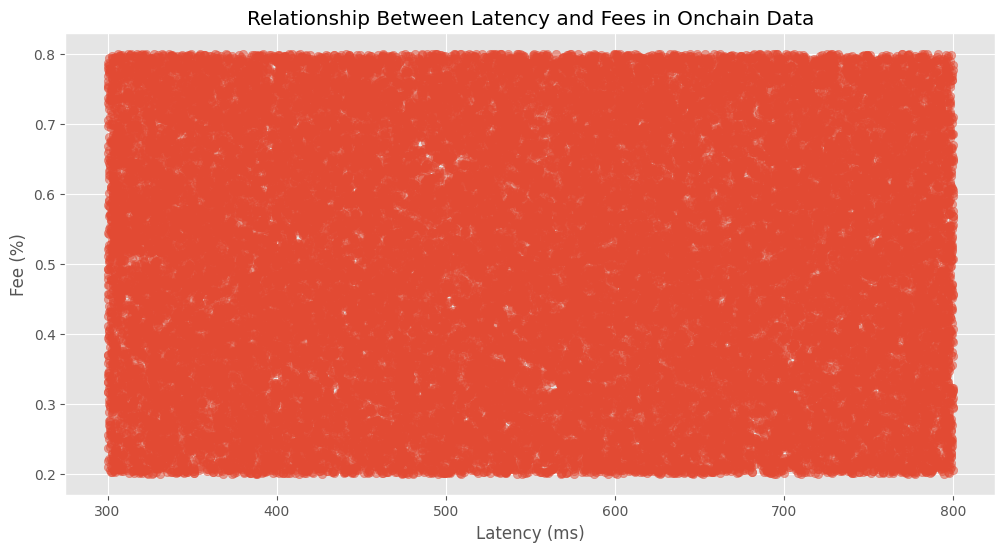

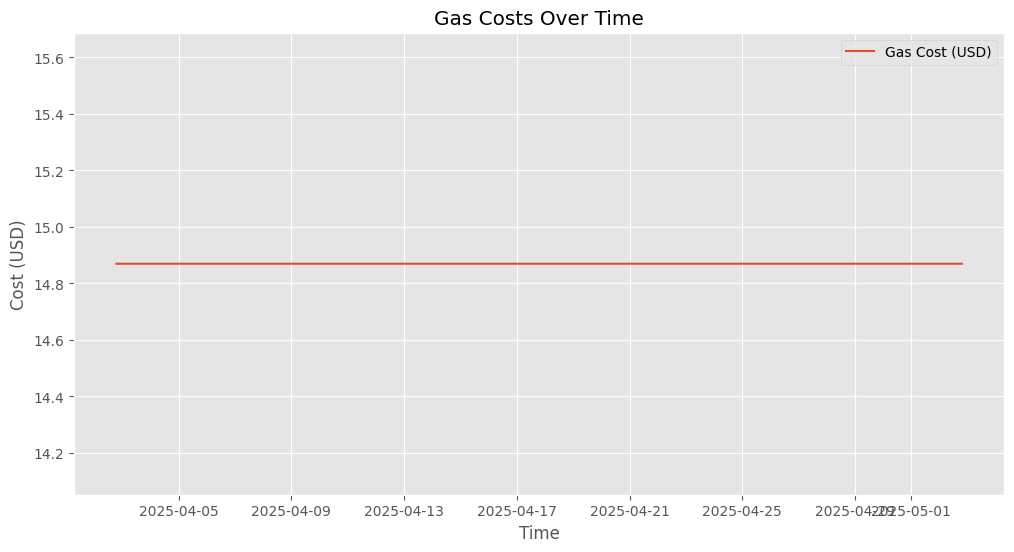

In [4]:
# Compare spreads between CEX and onchain
plt.figure(figsize=(12, 6))
plt.hist(onchain_data['spread'] * 100, bins=50, alpha=0.5, label='Onchain Spread (%)')
plt.axvline(onchain_data['spread'].mean() * 100, color='r', linestyle='--', label=f'Mean Onchain Spread: {onchain_data["spread"].mean()*100:.4f}%')
plt.title('Distribution of Onchain Spreads')
plt.xlabel('Spread (%)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Compare latency impact
plt.figure(figsize=(12, 6))
plt.scatter(onchain_data['latency_ms'], onchain_data['fee_pct'], alpha=0.5)
plt.title('Relationship Between Latency and Fees in Onchain Data')
plt.xlabel('Latency (ms)')
plt.ylabel('Fee (%)')
plt.grid(True)
plt.show()

# Compare gas costs
plt.figure(figsize=(12, 6))
plt.plot(onchain_data.index, onchain_data['gas_cost_usd'], label='Gas Cost (USD)')
plt.title('Gas Costs Over Time')
plt.xlabel('Time')
plt.ylabel('Cost (USD)')
plt.legend()
plt.grid(True)
plt.show()

## 3. Adapting Market Making for Onchain Trading

In [5]:
# Modify Avellaneda-Stoikov parameters for onchain trading
onchain_market_maker = AvellanedaStoikovModel(
    risk_aversion=1.5,  # Higher risk aversion for onchain
    time_horizon=0.5,   # Shorter time horizon due to higher volatility
    volatility=onchain_data['volatility'].mean() * 1.2  # Increase volatility estimate for safety
)

# Calculate quotes for onchain trading
sample_time = onchain_data.index[100]
sample_data = onchain_data.loc[sample_time]
mid_price = sample_data['mid_price']

# Set model parameters
onchain_market_maker.set_parameters(volatility=sample_data['volatility'] * 1.2)
onchain_market_maker.update_inventory(0)  # Start with zero inventory

# Calculate optimal quotes
bid_price, ask_price = onchain_market_maker.calculate_optimal_quotes(mid_price)

# Add gas cost adjustment to ask price and subtract from bid price
gas_cost_per_unit = sample_data['gas_cost_usd'] / 1.0  # Assuming 1 ETH trade
adjusted_bid = bid_price - gas_cost_per_unit
adjusted_ask = ask_price + gas_cost_per_unit

print(f"Mid Price: ${mid_price:.2f}")
print(f"Base Bid Price: ${bid_price:.2f}, Base Ask Price: ${ask_price:.2f}")
print(f"Gas Cost per Unit: ${gas_cost_per_unit:.2f}")
print(f"Gas-Adjusted Bid Price: ${adjusted_bid:.2f}, Gas-Adjusted Ask Price: ${adjusted_ask:.2f}")
print(f"Base Spread: ${ask_price - bid_price:.2f} ({(ask_price - bid_price) / mid_price * 100:.4f}%)")
print(f"Gas-Adjusted Spread: ${adjusted_ask - adjusted_bid:.2f} ({(adjusted_ask - adjusted_bid) / mid_price * 100:.4f}%)")

Mid Price: $1979.26
Base Bid Price: $1978.88, Base Ask Price: $1979.63
Gas Cost per Unit: $14.87
Gas-Adjusted Bid Price: $1964.01, Gas-Adjusted Ask Price: $1994.50
Base Spread: $0.75 (0.0377%)
Gas-Adjusted Spread: $30.49 (1.5403%)


## 4. Backtesting Onchain Market Making Strategy

In [6]:
# Initialize backtest engine for onchain trading
onchain_backtest_engine = BacktestEngine(
    market_data=onchain_data,
    initial_capital=10000.0,
    transaction_fee=0.003  # Higher fee for onchain
)

# Custom function to adjust quotes with gas costs
def gas_adjusted_quotes(model, mid_price, gas_cost):
    # Get base quotes from model
    bid_price, ask_price = model.calculate_optimal_quotes(mid_price)
    
    # Adjust for gas costs
    adjusted_bid = bid_price - gas_cost
    adjusted_ask = ask_price + gas_cost
    
    return adjusted_bid, adjusted_ask

# Prepare for backtesting
gas_costs = onchain_data['gas_cost_usd'].values
mid_prices = onchain_data['mid_price'].values

# Simulate trades with gas-adjusted quotes
trades = []
inventory = 0
capital = 10000.0
transaction_fee = 0.003

for i in range(len(onchain_data) - 1):
    # Get current data
    current_data = onchain_data.iloc[i]
    next_data = onchain_data.iloc[i+1]
    
    # Calculate gas-adjusted quotes
    gas_cost_per_unit = current_data['gas_cost_usd'] / 1.0  # For 1 ETH trade
    bid_price, ask_price = onchain_market_maker.calculate_optimal_quotes(current_data['mid_price'])
    adjusted_bid = max(0, bid_price - gas_cost_per_unit)  # Ensure non-negative
    adjusted_ask = ask_price + gas_cost_per_unit
    
    # Check if bid is executed (price falls below our bid)
    bid_executed = next_data['low'] <= adjusted_bid
    if bid_executed and inventory < 10:  # Limit inventory
        # Buy 1 unit
        inventory += 1
        capital -= adjusted_bid * (1 + transaction_fee)
        trades.append({
            'timestamp': next_data.name,
            'type': 'BUY',
            'price': adjusted_bid,
            'inventory': inventory,
            'capital': capital
        })
    
    # Check if ask is executed (price rises above our ask)
    ask_executed = next_data['high'] >= adjusted_ask
    if ask_executed and inventory > 0:
        # Sell 1 unit
        inventory -= 1
        capital += adjusted_ask * (1 - transaction_fee)
        trades.append({
            'timestamp': next_data.name,
            'type': 'SELL',
            'price': adjusted_ask,
            'inventory': inventory,
            'capital': capital
        })

# Convert to DataFrame
trades_df = pd.DataFrame(trades)

if not trades_df.empty:
    # Calculate final P&L
    final_price = onchain_data['mid_price'].iloc[-1]
    final_value = capital + inventory * final_price
    initial_value = 10000.0
    total_pnl = final_value - initial_value
    
    print(f"Total Trades: {len(trades_df)}")
    print(f"Final Inventory: {inventory}")
    print(f"Final Capital: ${capital:.2f}")
    print(f"Final Portfolio Value: ${final_value:.2f}")
    print(f"Total P&L: ${total_pnl:.2f} ({total_pnl/initial_value*100:.2f}%)")
    
    # Plot trades and performance
    if len(trades_df) > 0:
        plt.figure(figsize=(12, 8))
        plt.subplot(211)
        plt.plot(onchain_data.index, onchain_data['mid_price'], label='Mid Price')
        
        # Plot buy and sell points
        buys = trades_df[trades_df['type'] == 'BUY']
        sells = trades_df[trades_df['type'] == 'SELL']
        
        if not buys.empty:
            plt.scatter(buys['timestamp'], buys['price'], marker='^', color='g', label='Buy')
        if not sells.empty:
            plt.scatter(sells['timestamp'], sells['price'], marker='v', color='r', label='Sell')
            
        plt.title('Onchain Market Making: Trading Activity')
        plt.legend()
        plt.grid(True)
        
        # Plot portfolio value
        plt.subplot(212)
        plt.plot(trades_df['timestamp'], trades_df['capital'], label='Capital')
        plt.title('Capital Over Time')
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
else:
    print("No trades were executed in the simulation period.")

No trades were executed in the simulation period.
